In [35]:
'''
    PAQUETES UTILIZADOS
'''
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
from calendar import monthrange
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel

%matplotlib inline

In [36]:
'''
    FUNCION leeBD
    Regresa la base de datos "base" con valores numéricos
'''
def leeBD():
    # Lectura de la base de datos
    #base = pd.read_csv('OnlineNewsPopularity-Modified.csv', sep=",")
    base = pd.read_csv('OnlineNewsPopularity-Cat.csv', sep=",")
    base = base.copy()
    return base 

In [37]:
'''
    # Convertir dia de la semana de str a num 
    # Lunes es el 0
    weekdays = np.array(base.weekday.unique())
    for val in weekdays:
        base.ix[base['weekday'] == val, 'weekday'] = np.where(weekdays==val)

    # Convertir tipo de noticias de str a num
    # ['Entertainment', 'Business', 'Tech', 'LifeStyle', 'World', 'Unknown', 'SocMed']
    channels = np.array(base.data_channel.unique())
    for val in channels:
        base.ix[base['data_channel'] == val, 'data_channel'] = np.where(channels==val)  
'''

"\n    # Convertir dia de la semana de str a num \n    # Lunes es el 0\n    weekdays = np.array(base.weekday.unique())\n    for val in weekdays:\n        base.ix[base['weekday'] == val, 'weekday'] = np.where(weekdays==val)\n\n    # Convertir tipo de noticias de str a num\n    # ['Entertainment', 'Business', 'Tech', 'LifeStyle', 'World', 'Unknown', 'SocMed']\n    channels = np.array(base.data_channel.unique())\n    for val in channels:\n        base.ix[base['data_channel'] == val, 'data_channel'] = np.where(channels==val)  \n"

In [38]:
'''
    FUNCION rangoTimedelta
    Recibe el timedelta de una noticia
    Regresa los valores minimo y maximo del timedelta para acotar una semana, "minDelta" y "maxDelta"
'''
def rangoTimedelta(delta,periodo):
    # Fecha de adquisicion de los datos: January 8, 2015 (Thursday)
    dataAcq = dt.datetime(2015, 1, 8, 0, 0)
    
    # Fecha real de la noticia con base en el timedelta
    fechaNoticia = dataAcq - dt.timedelta(days=delta)
    # Dia de la semana y numero de semana correspondiente a la fecha
    dia = fechaNoticia.weekday()
    semana = fechaNoticia.isocalendar()[1]
    print fechaNoticia, " Dia: ", dia, ", ",periodo,": ",semana
    
    if periodo == 'semana':
        # Obtener la fecha de inicio y fin de la semana
        inicio = fechaNoticia - dt.timedelta(days=fechaNoticia.weekday())
        fin = inicio + dt.timedelta(days=7)
    else:
        # Obtener la fecha de inicio y fin del mes
        mes = fechaNoticia.month
        anio = fechaNoticia.year
        dias = np.max(monthrange(anio,mes))
        inicio = dt.datetime(anio, mes, 1, 0, 0)
        fin = dt.datetime(anio, mes, dias, 0, 0)

    # Diferencia de fechas entre la noticia y el inicio y fin de semana
    difInicio = fechaNoticia - inicio
    difFin = fin - fechaNoticia
    
    # Obtener timedelta compatible con los valores en la base de datos
    minDelta = delta - difInicio.days
    maxDelta = delta + difFin.days + 1
    
    return minDelta, maxDelta

In [39]:
'''
    FUNCION filtraBD
    Recibe la base de datos "base"
    Regresa una base "base2" filtrada por rango de tiempo
'''
def filtraBD(base,delta):
    # Obtener los timedelta correspondientes a la semana de la fecha con timedelta "delta"
    minDelta, maxDelta = rangoTimedelta(delta,'mes')
    
    # Filtrar la base por semana
    rangoFecha = range(minDelta, maxDelta)
    print "Rango timedeltas: ", rangoFecha
    base2 = base.loc[base['timedelta'].isin(rangoFecha)]
    
    return base2

In [40]:
'''
    FUNCION conjEntrenamiento
    Recibe una base de datos "base2"
    Regresa el conjunto de entrenamiento "base_X" y el conjunto objetivo "base_y"
'''
def limpiaDatos(base):
    # Copia de la base sin la primer columna ('url', atributo no predictivo) y sin la variable objetivo
    # Matriz de entrenamiento
    base_X = base.drop(base.columns[[0,1,len(base.columns)-1]], axis=1)

    # Arreglo de valores objetivo (columna de valores objetivo 'shares')
    base_y = np.asarray(base[base.columns[len(base.columns)-1]].tolist())
    
    return base_X, base_y

In [41]:
'''
    FUNCION error_fn
    Recibe el arreglo con valores a predecir "X_predict", el arreglo de valores esperados "y_test"
        y el valor de tolerancia "k"
    Regresa el porcentaje de acierto de la predicción
'''
def error_fn(y_predict, y_test, k):
    i = 0
    yei = 0
    for i in range(len(y_predict)):
        if np.absolute(y_predict[i] - y_test[i]) < k:
            yei = yei + 1
    return yei/float(len(y_predict))

In [42]:
'''
    ************ OBTENCION DE LOS CONJUNTOS DE DATOS Y DE VALORES OBJETIVO ************
'''
# Lectura de la base de datos
base = leeBD()

print "Forma de la base inicial: ",base.shape

# La fecha mas antigua es el 7 de enero del 2013 (timedelta = 731)
# La fecha mas reciente es el 31 de diciembre del 2014 (timedelta = 8)
# El timedelta 372 corresponde al inicio del 2014
delta = 200
print "Timedelta: ", delta

# Filtrado de la base de datos por semana
base2 = filtraBD(base,delta)
print "\nForma de la base filtrada por tiempo: ",base2.shape

Forma de la base inicial:  (39644, 61)
Timedelta:  200
2014-06-22 00:00:00  Dia:  6 ,  mes :  25
Rango timedeltas:  [179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208]

Forma de la base filtrada por tiempo:  (1839, 61)


In [43]:
'''
    OBTENCION DE LOS SUBCONJUNTOS CON VALORES PREDICTIVOS Y VALORES OBJETIVO
'''
# Separacion de conjuntos entrenamiento y valores objetivo
base_X, base_y = limpiaDatos(base2)
print "Forma de la base sin valores no-predictivos: ",base_X.shape

Forma de la base sin valores no-predictivos:  (1839, 58)


In [44]:
'''
    SELECCION DE ATRIBUTOS BASADA EN ÁRBOL
'''
clf = ExtraTreesClassifier()
clf = clf.fit(base_X, base_y)
model = SelectFromModel(clf, prefit=True)
base_X_new = model.transform(base_X)
print "Forma de la base tras la seleccion de atributos: ",base_X_new.shape

Forma de la base tras la seleccion de atributos:  (1839, 40)


In [45]:
'''
    OBTENCION DE LOS SUBCONJUNTOS PARA ENTRENAMIENTO Y DE PRUEBA
'''
# Obtenemos dos subconjuntos de datos (75% para entrenamiento, 25% para prueba)
# len(X_train) = len(y_train)
# len(X_test) = len(y_test)
# Los índices de ambos conjuntos (train o test) se corresponden de acuerdo a la base de datos original
X_train, X_test, y_train, y_test = train_test_split(base_X_new, base_y, test_size=0.25)

# Estandarización de los datos con respecto a su subconjunto
X_train = StandardScaler().fit_transform(X_train, y_train)

In [46]:
'''
    EJECUCION DEL ALGORITMO PARA ENTRENAR LOS DATOS
'''
# Creación de una instancia de 'Neighbours Classifier'
# Sin atributos, se analizan los datos y se eligen la mejor forma de obtener los k-vecinos
neigh = KNeighborsClassifier()
#neigh = KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='auto', n_jobs=-1)

# Entrenamiento de los datos
neigh = neigh.fit(X_train,y_train)

In [47]:
'''
    PREDICCION CON EL SUBCONJUNTO DE PRUEBA
'''
# Predicción de valores objetivo con el conjunto de prueba
# En teoría, y_predict debería ser igual a y_test
y_predict = neigh.predict(X_test)

# Exactitud promedio de la predicción calculada con la librería
accuracy = neigh.score(X_test, y_test)
print 'Exactitud promedio: ', accuracy

Exactitud promedio:  0.323913043478


Máximo acierto con k = 150


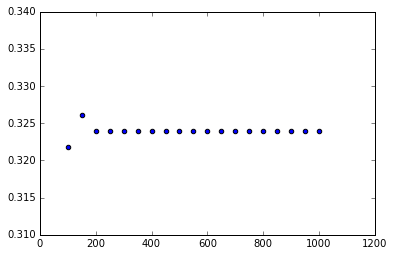

In [48]:
'''
    OBTENCION DE UN K MAXIMO KNN
    %Acierto vs. K
'''
# Cálculo de error para k vecinos (rango [100 : 50 : 1000])
err_arr = []
arr = np.arange(100, 1050, 50)
for i in arr:
    neigh = KNeighborsClassifier(n_neighbors=i, n_jobs=-1)
    neigh.fit(X_train,y_train)
    X_predict = neigh.predict(X_test)
    # Rango de tolerancia de 500 vecinos
    err = neigh.score(X_test, y_test)
    err_arr.append(err)

# Graficación de resultados
plt.scatter(arr, err_arr)

# Encontrar el k máximo con esta prueba
index = err_arr.index(max(err_arr))
maxi = arr[index]
print 'Máximo acierto con k =', maxi

In [49]:
'''
    PRUEBAS DE MARGEN DE ERROR
    Con el k máximo obtenido "maxi"
'''
neigh = KNeighborsClassifier(n_neighbors=maxi, n_jobs=-1)
neigh.fit(X_train,y_train)
y_predict = neigh.predict(X_test)

# Exactitud promedio de la predicción calculada con la librería
accuracy = neigh.score(X_test, y_test)
print 'Exactitud promedio: ', accuracy

Exactitud promedio:  0.326086956522
